In [2]:
import cv2
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from skimage import feature
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [3]:
#split dataset into train,test
# Constants
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [4]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        for imagename in os.listdir(os.path.join(directory, label)):
            image_paths.append(os.path.join(directory, label, imagename))
            labels.append(label)
    return pd.DataFrame({'image': image_paths, 'label': labels})

In [5]:
# Load image data into dataframes
train_df = create_dataframe(TRAIN_DIR)
test_df = create_dataframe(TEST_DIR)

In [6]:
# Function to extract features from images
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
        img_array = img_to_array(img)
        features.append(img_array)
    return np.array(features)

In [7]:
train_features = extract_features(train_df['image'])
test_features = extract_features(test_df['image'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7066/7066 [01:15<00:00, 93.75it/s]


In [8]:
# Reshape the images to have the correct shape
train_features = train_features.reshape(-1, 48, 48, 1)
test_features = test_features.reshape(-1, 48, 48, 1)

In [9]:
# Normalize pixel values
x_train = train_features / 255.0
x_test = test_features / 255.0

In [10]:
from sklearn.preprocessing import LabelEncoder
# Encode labels
le = LabelEncoder()
le.fit(train_df['label'])

LabelEncoder()

In [11]:
y_train = to_categorical(le.transform(train_df['label']), num_classes=7)
y_test = to_categorical(le.transform(test_df['label']), num_classes=7)

In [12]:
# Split the data for training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [13]:
# Train CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

C:\Users\MAC-10413\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.3081 - loss: 1.7310 - val_accuracy: 0.4097 - val_loss: 1.5265
Epoch 2/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4444 - loss: 1.4471 - val_accuracy: 0.4782 - val_loss: 1.3690
Epoch 3/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5048 - loss: 1.3028 - val_accuracy: 0.4843 - val_loss: 1.3483
Epoch 4/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5534 - loss: 1.1900 - val_accuracy: 0.5077 - val_loss: 1.2843
Epoch 5/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5882 - loss: 1.0922 - val_accuracy: 0.5107 - val_loss: 1.2849
Epoch 6/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.6337 - loss: 0.9894 - val_accuracy: 0.5141 - val_loss: 1.3280
Epoch 7/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6655 - loss: 0.8907 - val_accuracy: 0.5131 - val_loss: 1.3333
Epoch 8/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.7171 - loss: 0.7794 - 

In [15]:
cnn_eval = cnn_model.evaluate(x_val, y_val)
print("CNN Model - Loss: {:.4f}, Accuracy: {:.4f}".format(cnn_eval[0], cnn_eval[1]))

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5159 - loss: 1.5886
CNN Model - Loss: 1.6241, Accuracy: 0.5155


In [16]:
# Predictions on the test set
cnn_predictions = cnn_model.predict(x_test)
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)
cnn_true_labels = np.argmax(y_test, axis=1)

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


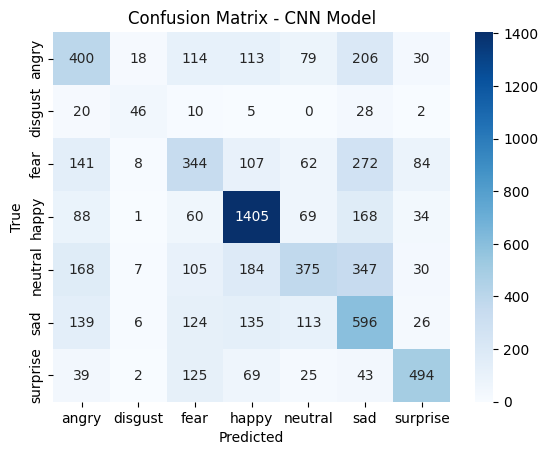

In [17]:
label = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Confusion Matrix for CNN Model
cnn_cm = confusion_matrix(cnn_true_labels, cnn_pred_labels)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Classification Report for CNN Model
cnn_classification_report = classification_report(cnn_true_labels, cnn_pred_labels, target_names=label)
print("Classification Report - CNN Model:")
print(cnn_classification_report)

Classification Report - CNN Model:
              precision    recall  f1-score   support

       angry       0.40      0.42      0.41       960
     disgust       0.52      0.41      0.46       111
        fear       0.39      0.34      0.36      1018
       happy       0.70      0.77      0.73      1825
     neutral       0.52      0.31      0.39      1216
         sad       0.36      0.52      0.43      1139
    surprise       0.71      0.62      0.66       797

    accuracy                           0.52      7066
   macro avg       0.51      0.48      0.49      7066
weighted avg       0.53      0.52      0.51      7066



In [19]:
# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train.reshape(x_train.shape[0], -1), np.argmax(y_train, axis=1))


RandomForestClassifier(random_state=42)

In [20]:
# Flatten the image data
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)

# Predictions on the validation set
rf_predictions = rf_model.predict(x_val_flat)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(np.argmax(y_val, axis=1), rf_predictions)
print("Random Forest Model - Accuracy: {:.4f}".format(rf_accuracy))

Random Forest Model - Accuracy: 0.4486


In [21]:
# Predictions on the test set for Random Forest Model
rf_predictions = rf_model.predict(x_test.reshape(x_test.shape[0], -1))

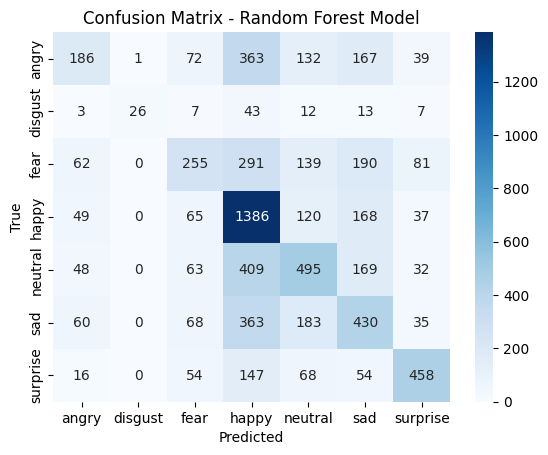

In [22]:
# Confusion Matrix for Random Forest Model
rf_cm = confusion_matrix(np.argmax(y_test, axis=1), rf_predictions)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix - Random Forest Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# Classification Report for Random Forest Model
rf_classification_report = classification_report(np.argmax(y_test, axis=1), rf_predictions, target_names=label)
print("Classification Report - Random Forest Model:")
print(rf_classification_report)

Classification Report - Random Forest Model:
              precision    recall  f1-score   support

       angry       0.44      0.19      0.27       960
     disgust       0.96      0.23      0.38       111
        fear       0.44      0.25      0.32      1018
       happy       0.46      0.76      0.57      1825
     neutral       0.43      0.41      0.42      1216
         sad       0.36      0.38      0.37      1139
    surprise       0.66      0.57      0.62       797

    accuracy                           0.46      7066
   macro avg       0.54      0.40      0.42      7066
weighted avg       0.46      0.46      0.44      7066



In [24]:
# Train SVM Model
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(x_train_flat, np.argmax(y_train, axis=1))

SVC(C=1, kernel='linear', random_state=42)

In [25]:
# Predictions on the validation set
svm_predictions = svm_model.predict(x_val_flat)

# Evaluate the SVM model
svm_accuracy = accuracy_score(np.argmax(y_val, axis=1), svm_predictions)
print("SVM Model - Accuracy: {:.4f}".format(svm_accuracy))

SVM Model - Accuracy: 0.3339


In [26]:
# Predictions on the test set for SVM Model
svm_predictions = svm_model.predict(x_test.reshape(x_test.shape[0], -1))

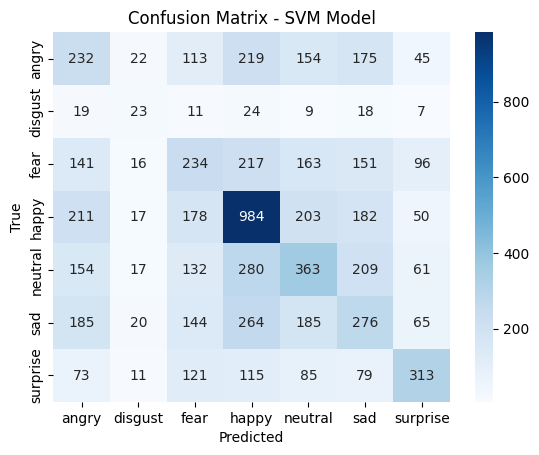

In [27]:
# Confusion Matrix for SVM Model
svm_cm = confusion_matrix(np.argmax(y_test, axis=1), svm_predictions)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix - SVM Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
# Classification Report for SVM Model
svm_classification_report = classification_report(np.argmax(y_test, axis=1), svm_predictions, target_names=label)
print("Classification Report - SVM Model:")
print(svm_classification_report)

Classification Report - SVM Model:
              precision    recall  f1-score   support

       angry       0.23      0.24      0.23       960
     disgust       0.18      0.21      0.19       111
        fear       0.25      0.23      0.24      1018
       happy       0.47      0.54      0.50      1825
     neutral       0.31      0.30      0.31      1216
         sad       0.25      0.24      0.25      1139
    surprise       0.49      0.39      0.44       797

    accuracy                           0.34      7066
   macro avg       0.31      0.31      0.31      7066
weighted avg       0.34      0.34      0.34      7066



In [29]:
# Predictions on the validation set
rf_predictions = rf_model.predict(x_val_flat)

# Predictions on the validation set
svm_predictions = svm_model.predict(x_val_flat)

# Compare and select the best model based on accuracy
best_model = None
best_accuracy = 0.0

# Evaluate CNN Model
cnn_eval = cnn_model.evaluate(x_val, y_val)
cnn_accuracy = cnn_eval[1]  # Assuming accuracy is at index 1 in the evaluation results

if cnn_accuracy > best_accuracy:
    best_model = cnn_model
    best_accuracy = cnn_accuracy

# Evaluate Random Forest Model
rf_accuracy = accuracy_score(np.argmax(y_val, axis=1), rf_predictions)

if rf_accuracy > best_accuracy:
    best_model = rf_model
    best_accuracy = rf_accuracy

# Evaluate SVM Model
svm_accuracy = accuracy_score(np.argmax(y_val, axis=1), svm_predictions)

if svm_accuracy > best_accuracy:
    best_model = svm_model
    best_accuracy = svm_accuracy

# Print the best model and its accuracy
print("Best Model: {}, Accuracy: {:.4f}".format(best_model.__class__.__name__, best_accuracy))


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5159 - loss: 1.5886
Best Model: Sequential, Accuracy: 0.5155


In [30]:
# Save the best model
best_model.save("best_emotion_model.h5")

In [31]:
# Load the best model for predictions
loaded_model = best_model  # Update this line with the appropriate loading mechanism for your model

In [32]:
# Define the label list
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

# Function to load and preprocess an image for prediction
def load_and_preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, 48, 48, 1))
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

In [33]:
# Example usage for predicting with the loaded model
image_path = 'images/train/sad/42.jpg'
print("Original image is of sad")
img = load_and_preprocess_image(image_path)
pred = loaded_model.predict(img)
pred_label = label[np.argmax(pred)]
print("Model prediction is", pred_label)

Original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Model prediction is sad


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

Original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Model prediction is sad


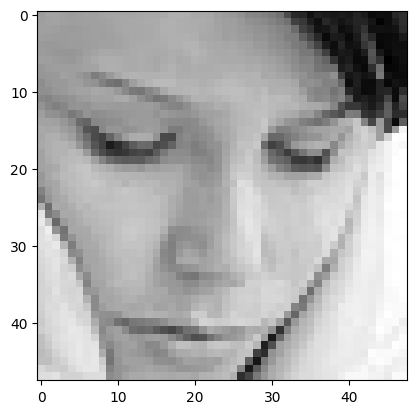

In [35]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def ef(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    feature = img_to_array(img)
    feature = feature.reshape(48, 48)  # Remove unnecessary reshaping
    feature = feature / 255.0  # Normalize pixel values
    return feature

# Example usage:
image_path = 'images/train/sad/42.jpg'
print("Original image is of sad")
img = ef(image_path)
pred = loaded_model.predict(img.reshape(1, 48, 48, 1))  # Reshape for prediction
pred_label = label[pred.argmax()]
print("Model prediction is", pred_label)

# Display the image directly without reshaping
plt.imshow(img, cmap='gray')
plt.show()

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Model prediction is sad


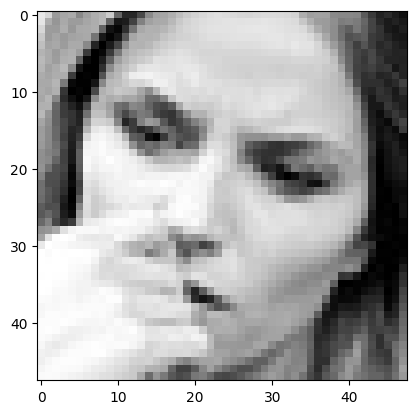

In [36]:
image_path = 'images/train/fear/2.jpg'
print("original image is of fear")
img = ef(image_path)
pred = loaded_model.predict(img.reshape(1, 48, 48, 1))  # Reshape for prediction
pred_label = label[pred.argmax()]
print("Model prediction is", pred_label)

# Display the image directly without reshaping
plt.imshow(img, cmap='gray')
plt.show()

original image is of surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model prediction is surprise


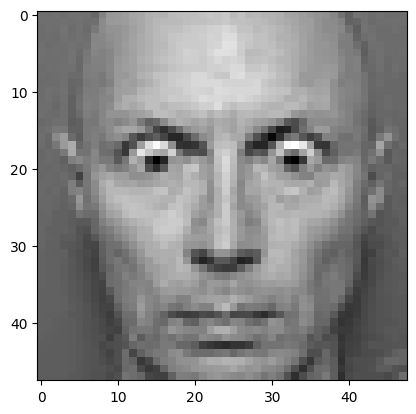

In [37]:
image_path = 'images/train/surprise/15.jpg'
print("original image is of surprise")
img = ef(image_path)
pred = loaded_model.predict(img.reshape(1, 48, 48, 1))  # Reshape for prediction
pred_label = label[pred.argmax()]
print("Model prediction is", pred_label)

# Display the image directly without reshaping
plt.imshow(img, cmap='gray')
plt.show()

In [38]:
import cv2
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# Load the best-trained model
best_model = load_model("best_emotion_model.h5")

In [39]:
# Define the label list
label = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [40]:
# Haar Cascade for face detection
haar_file = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_file)

def extract_features(image):
    feature = np.array(image)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0


In [ ]:
#open webcam
webcam=cv2.VideoCapture(0)

labels = {0 : 'angry', 1 : 'disgust', 2 : 'fear', 3 : 'happy', 4 : 'neutral', 5 : 'sad', 6 : 'surprise'}
while True:
    i,im=webcam.read()
    gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(im,1.3,5)
    try: 
        for (p,q,r,s) in faces:
            image = gray[q:q+s,p:p+r]
            cv2.rectangle(im,(p,q),(p+r,q+s),(255,0,0),2)
            image = cv2.resize(image,(48,48))
            img = extract_features(image)
            pred = loaded_model.predict(img)
            prediction_label = labels[pred.argmax()]
            # print("Predicted Output:", prediction_label)
            # cv2.putText(im,prediction_label)
            cv2.putText(im, '% s' %(prediction_label), (p-10, q-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,2, (0,0,255))
        cv2.imshow("Output",im)
        cv2.waitKey(27)
    except cv2.error:
        pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━